In the following notebook we present you feature engineering and early modelling for census income dataset.

# Data preparation and feature engineering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

df_original = pd.read_csv("census_income_dataset.csv")
df_columns_info = pd.read_csv("attributes_census_income.csv")

df = df_original.replace('?',np.nan).replace(-100000, np.nan)

In [2]:
# split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='income_level'), df['income_level'], test_size=0.2, random_state=42)
# może dodać parametr stratify = df['income_level'] żeby zachować proporcje

Target class ratio is preserved after split.

In [3]:
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

<=50K    0.761165
>50K     0.238835
Name: income_level, dtype: float64
<=50K    0.758931
>50K     0.241069
Name: income_level, dtype: float64


## Imputing values
Three categorical features have missing values.

We found an imputation method called MissTree. Basically, that's an imputer based on random forest, which is predicting missing values based on known values and available features. Some of the predicted values are used as training data for a random forest to predict the rest of missing values, this process is repeated several times and improving imputations. This solution can be applied for mixed type of columns, require no preprocessing (except conversion of categories to integers), can use Out of Bag error (cross-validation is not needed) and uses information from all features. The biggest disadvantage is that it must be run every data is imputed.
More explanation is [here](https://www.numpyninja.com/post/missforest-one-of-the-best-imputational-methods), for detailed information there is also [an article](https://arxiv.org/pdf/1105.0828.pdf) about this algorithm. 

Let's measure its performance on our dataset and compare it to SimpleImputer. To measure imputation quality, we take a non-missing-values subset of data and remove values randomly from workclass and occupation with a similar rate (~8%). Then, we compare imputations with actual values that were removed. We repeat this process 20 times. 

In [4]:
df.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     857
income_level         0
dtype: int64

In [7]:
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
row_list = []


categorical = ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
numerical = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# function to randomly remove values from column
def random_remove_values(df, col, rate):
    indices_of_vals_to_remove = np.random.choice(df.index.values, size=int(len(df) * rate))
    output_df = df.copy()
    output_df.loc[indices_of_vals_to_remove, col] = np.nan
    return output_df, indices_of_vals_to_remove

# function to convert categorical features into int values
def factorize_categories(df, cat_columns):
    df[categorical] = df[categorical].astype('category')
    factorized = df[categorical].apply(lambda col: col.factorize()[0])
    cat_indexes = df[categorical].apply(lambda col: col.factorize()[1])
    df[categorical] = factorized
    df = df.replace(-1, np.nan)
    return df, cat_indexes


for i in range(20):
    x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='income_level'), df['income_level'], test_size=0.2, random_state=42)
    x_train = x_train.dropna()[[*categorical, *numerical]]

    # removing some values from two columns
    x_train_removed, removed_indexes = random_remove_values(x_train, 'workclass', 0.08)
    x_train_removed, removed_indexes_occupation = random_remove_values(x_train_removed, 'occupation', 0.8)


    x_fac_removed, cat_indexes = factorize_categories(x_train_removed, categorical)
    x_fac, _ = factorize_categories(x_train, categorical)

    # imputing with MissForest, it needs to specify which columns are categorical
    cat_columns_indexes = [x_fac_removed.columns.get_loc(col) for col in x_fac_removed[categorical].columns.tolist()]
    imputer = MissForest(max_iter=10, max_depth=10, oob_score=True)
    imputed_missforest = imputer.fit_transform(x_fac_removed, cat_vars=cat_columns_indexes)
    imputed_missforest = pd.DataFrame(imputed_missforest, columns=x_fac_removed.columns).set_index(x_fac_removed.index)


    simple_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputed_simple = simple_imputer.fit_transform(x_fac_removed)
    imputed_simple = pd.DataFrame(imputed_simple, columns=x_fac_removed.columns).set_index(x_fac_removed.index)

    # comparing imputed values to actual
    row_list.append({'missforest_workclass':imputed_missforest.loc[removed_indexes, 'workclass'].ne(x_fac.loc[removed_indexes, 'workclass']).value_counts()[False]/len(removed_indexes),
                     'simple_workclass':imputed_simple.loc[removed_indexes, 'workclass'].ne(x_fac.loc[removed_indexes, 'workclass']).value_counts()[False]/len(removed_indexes),
                     'missforest_occupation': imputed_missforest.loc[removed_indexes_occupation, 'occupation'].ne(x_fac.loc[removed_indexes_occupation, 'occupation']).value_counts()[False]/len(removed_indexes_occupation),
                     'simple_occupation': imputed_simple.loc[removed_indexes_occupation, 'occupation'].ne(x_fac.loc[removed_indexes_occupation, 'occupation']).value_counts()[False]/len(removed_indexes_occupation)})

results = pd.DataFrame(row_list)           

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2


As we can see in the plot below, both imputers perform pretty much the same. So for our case `SimpleImputer` is a better option, because of its simplicity. This sort of outcome is probably caused by highly unbalanced distributions of imputed features (what is favorable for `SimpleImputer`, which fills missing data with the most common value).

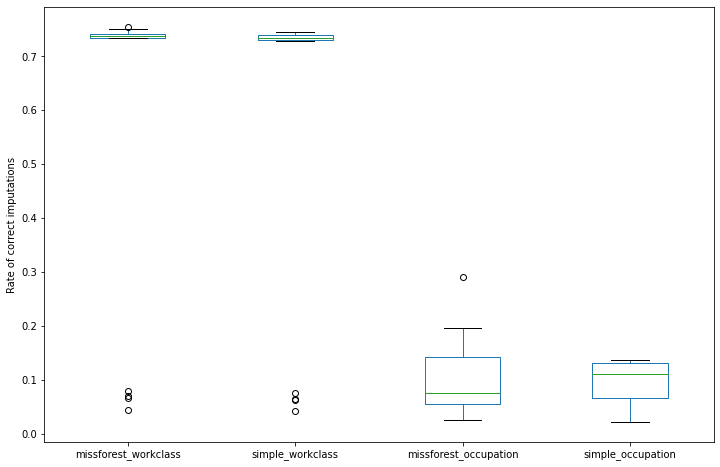

In [8]:
results.plot.box(figsize=(12,8))
plt.ylabel('Rate of correct imputations')
plt.show()

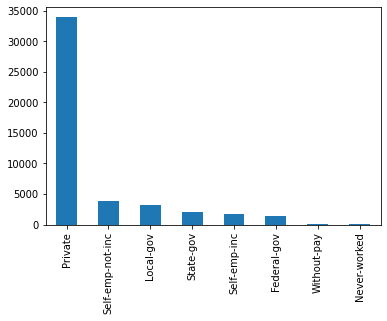

In [9]:
df['workclass'].value_counts().plot.bar()
plt.show()

Firstly, we dropped three columns, which were redundant: fnlwgt, education (information is already encoded in education_num) and relationship (simmilar information is in maritial status column).
Secondly, we grouped people in relationships into one group: married.
At the end, we marked countries with shares income <=50k above mean (which de facto means above share in th USA) as country_more_USA and shares below mean as country_less_USA.

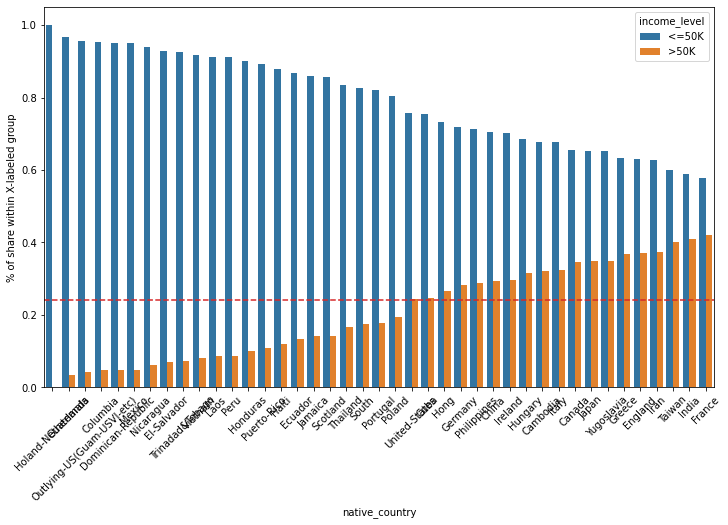

In [ ]:
def plot_shares(columns_name):
    x = df.groupby(['income_level', columns_name])['age'].agg(['count'])
    shares = x / x.groupby(level=1).sum()
    fig, ax = plt.subplots()
    g = sns.barplot(data=shares.reset_index().sort_values(by=['income_level','count'],
                                                          ascending=[True,False]), x=columns_name, y='count', hue='income_level')
    fig.set_size_inches(12,7)
    ax.axhline(0.24, ls='--', color='C3')
    plt.xticks(rotation=45)
    plt.ylabel('% of share within X-labeled group')
    plt.show()

plot_shares('native_country')

In [ ]:
df = df.drop(['fnlwgt', 'education', 'relationship'], axis= 1)

# maritial status
df['married'] = np.where(df.marital_status.isin(['Married-civ-spouse', 'Married-AF-spouse']), 'married', 'not_married')
df = df.drop(['marital_status'], axis = 1)

# country
x = df.groupby(['income_level', 'native_country'])['age'].agg(['count'])
shares = x / x.groupby(level=1).sum()
shares = shares.reset_index()
shares = shares[shares.income_level == '<=50K']

share_USA = shares[shares.native_country == 'United-States']['count'].values[0]

df['country_less_USA'] = np.where(df['native_country'].isin(shares[shares['count'] < share_USA]['native_country']), 'country_less_USA', 'NOT_country_less_USA')
df['country_more_USA'] = np.where(df['native_country'].isin(shares[shares['count'] > share_USA]['native_country']), 'country_more_USA', 'NOT_more_less_USA')

df = df.drop(['native_country'], axis = 1)

In [ ]:
df['country_USA'] = np.where((df['country_less_USA'] + df['country_more_USA']) == 0, 'country_USA', 'NOT_country_USA')

In [ ]:
df.head()

,age,workclass,education_num,occupation,race,sex,capital_gain,capital_loss,hours_per_week,income_level,married,country_less_USA,country_more_USA,country_USA
0,39,State-gov,13,Adm-clerical,White,Male,2174.0,0.0,40.0,<=50K,not_married,NOT_country_less_USA,NOT_more_less_USA,NOT_country_USA
1,50,Self-emp-not-inc,13,Exec-managerial,White,Male,0.0,0.0,13.0,<=50K,married,NOT_country_less_USA,NOT_more_less_USA,NOT_country_USA
2,38,Private,9,Handlers-cleaners,White,Male,0.0,0.0,40.0,<=50K,not_married,NOT_country_less_USA,NOT_more_less_USA,NOT_country_USA
3,53,Private,7,Handlers-cleaners,Black,Male,0.0,0.0,40.0,<=50K,married,NOT_country_less_USA,NOT_more_less_USA,NOT_country_USA
4,28,Private,13,Prof-specialty,Black,Female,0.0,0.0,40.0,<=50K,married,country_less_USA,NOT_more_less_USA,NOT_country_USA


Then we divided data to training and testing set.

In [ ]:
# split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='income_level'), df['income_level'], test_size=0.2, random_state=42)

y label is split equally across sets as seen below.

In [ ]:
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

<=50K    0.761165
>50K     0.238835
Name: income_level, dtype: float64
<=50K    0.758931
>50K     0.241069
Name: income_level, dtype: float64


The last step before proceeding to next step is creating a pipeline. In this pipeline categorical variables are imputed with simple imputer and then one-hot encoded. Numerical features are transformed using standard scaler only.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
categorical = ['workclass', 'occupation', 'race', 'sex', 'married','country_USA' ,'country_less_USA', 'country_more_USA']
numerical = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

numeric_transformer = StandardScaler()

# placeholder for encoding categorical variables
categorical_transformer = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                    ('onehot_encoding', OneHotEncoder(drop='first')) ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

# Testing different models



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

random_state = 3845673

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=random_state)

pipeline_lr = make_pipeline(preprocessor, lr)

pipeline_lr.fit(X_train, y_train)
pipeline_lr.score(X_train, y_train)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8517134594221073

In [ ]:
pipeline_lr.score(X_test, y_test)

0.8499334629951889

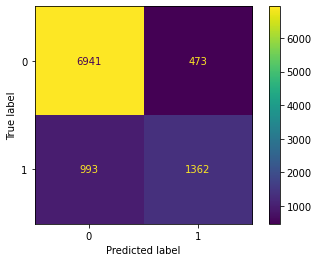

              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90      7414
        >50K       0.74      0.58      0.65      2355

    accuracy                           0.85      9769
   macro avg       0.81      0.76      0.78      9769
weighted avg       0.84      0.85      0.84      9769



In [ ]:
y_predicted = pipeline_lr.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format = 'd')
plt.show()
print(classification_report(y_test, y_predicted))

##### Feature importance for Logistic Regression

Function below is used for recovering column names of data processed with pipeline. 

In [ ]:
# source: https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html

def get_feature_names(column_transformer):
    import warnings
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Transformer num (type StandardScaler) does not provide get_feature_names. Will return input column names if available
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available


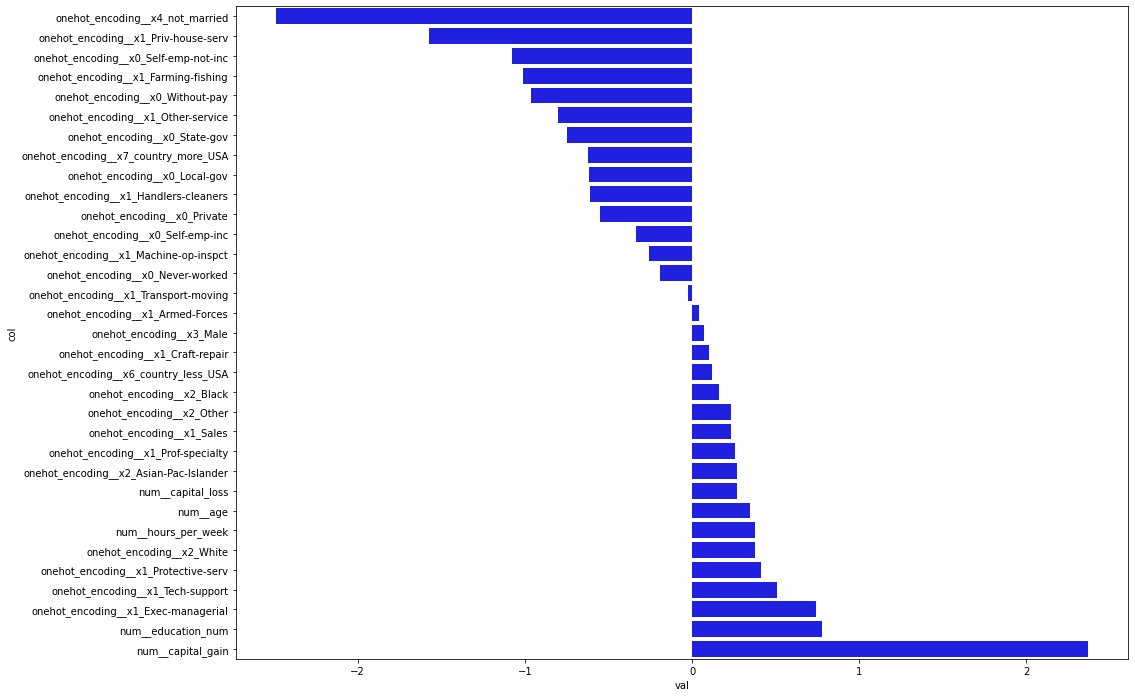

In [ ]:
tmp = pd.DataFrame({'val' : pipeline_lr.steps[1][1].coef_.flatten(), 'col' : get_feature_names(preprocessor)})
tmp = tmp.sort_values(by = 'val')

plt.figure(figsize=(16, 12))
sns.barplot(y="col", x="val", data=tmp, color='blue');

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=10, random_state=random_state)

pipeline_rf = make_pipeline(preprocessor, rf)

pipeline_rf.fit(X_train, y_train)
pipeline_rf.score(X_train, y_train)

0.867350856089883

In [ ]:
pipeline_rf.score(X_test, y_test)

0.8576108097041663

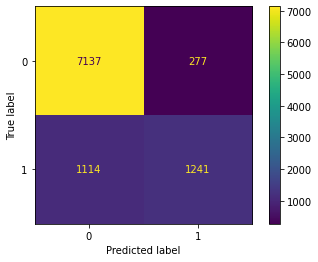

              precision    recall  f1-score   support

       <=50K       0.86      0.96      0.91      7414
        >50K       0.82      0.53      0.64      2355

    accuracy                           0.86      9769
   macro avg       0.84      0.74      0.78      9769
weighted avg       0.85      0.86      0.85      9769



In [ ]:
y_predicted = pipeline_rf.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format = 'd')
plt.show()
print(classification_report(y_test, y_predicted))

##### Feature importance for Random Forest

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Transformer num (type StandardScaler) does not provide get_feature_names. Will return input column names if available
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available


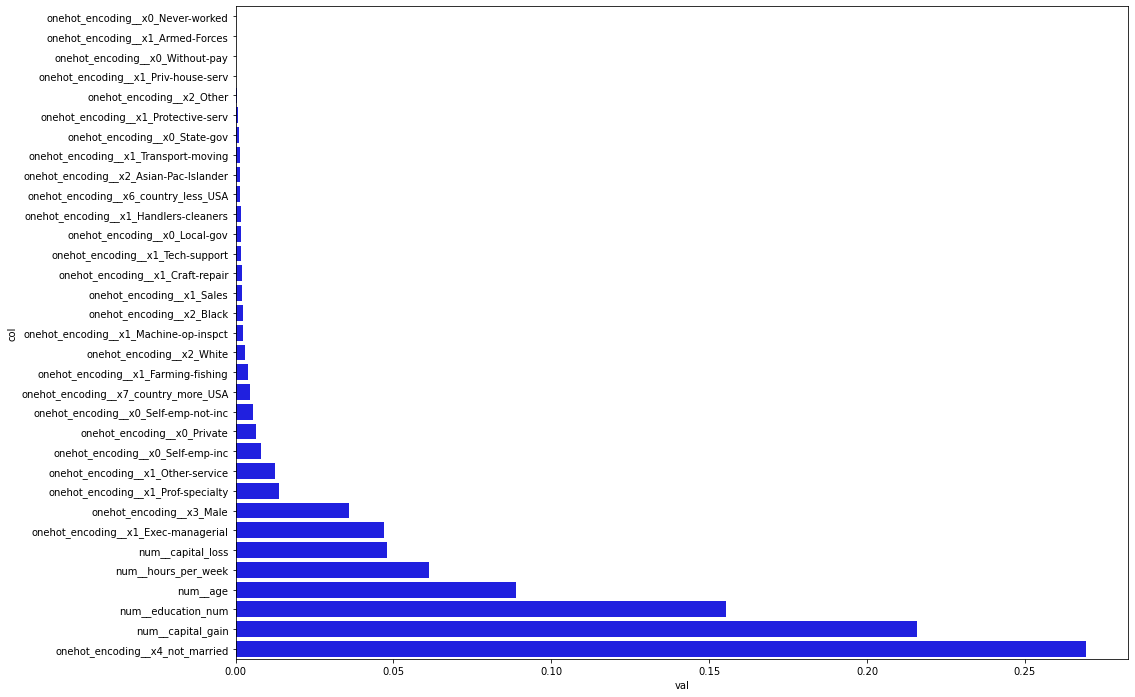

In [ ]:
tmp = pd.DataFrame({'val' : pipeline_rf.steps[1][1].feature_importances_, 'col' : get_feature_names(preprocessor)})
tmp = tmp.sort_values(by = 'val')

plt.figure(figsize=(16, 12))
sns.barplot(y="col", x="val", data=tmp, color = 'blue');

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=10, random_state=random_state)

pipeline_dt = make_pipeline(preprocessor, dt)

pipeline_dt.fit(X_train, y_train)
pipeline_dt.score(X_train, y_train)

0.8690144089268804

In [ ]:
pipeline_dt.score(X_test, y_test)

0.858941549800389

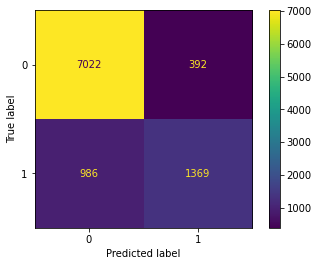

              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      7414
        >50K       0.78      0.58      0.67      2355

    accuracy                           0.86      9769
   macro avg       0.83      0.76      0.79      9769
weighted avg       0.85      0.86      0.85      9769



In [ ]:
y_predicted = pipeline_dt.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format = 'd')
plt.show()
print(classification_report(y_test, y_predicted))

##### Feature importance for Decision Tree

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Transformer num (type StandardScaler) does not provide get_feature_names. Will return input column names if available
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available


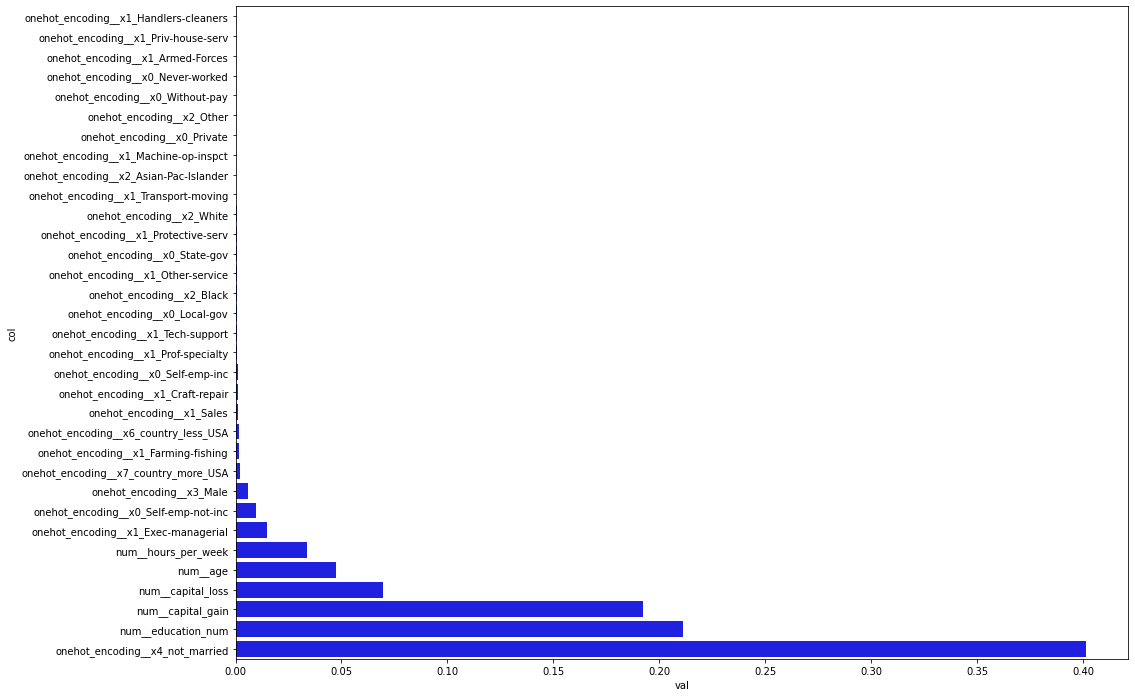

In [ ]:
tmp = pd.DataFrame({'val' : pipeline_dt.steps[1][1].feature_importances_, 'col' : get_feature_names(preprocessor)})
tmp = tmp.sort_values(by = 'val')

plt.figure(figsize=(16, 12))
sns.barplot(y="col", x="val", data=tmp, color = 'blue');

### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

svm = SVC(random_state=random_state)

pipeline_svm = make_pipeline(preprocessor, svm)

pipeline_svm.fit(X_train, y_train)
pipeline_svm.score(X_train, y_train)

0.8621298594937681

In [ ]:
pipeline_svm.score(X_test, y_test)

0.8555635172484389

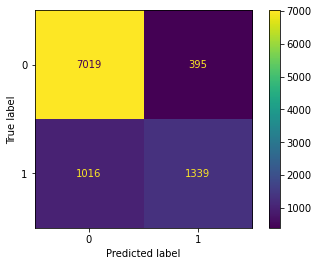

              precision    recall  f1-score   support

       <=50K       0.87      0.95      0.91      7414
        >50K       0.77      0.57      0.65      2355

    accuracy                           0.86      9769
   macro avg       0.82      0.76      0.78      9769
weighted avg       0.85      0.86      0.85      9769



In [ ]:
y_predicted = pipeline_svm.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format = 'd')
plt.show()
print(classification_report(y_test, y_predicted))

### XGBoost

In [ ]:
import xgboost as xgb

param = {'objective':'binary:logistic'}
xgb = xgb.XGBClassifier(objective='binary:logistic', max_depth=5,random_state=random_state)

pipeline_xgb = make_pipeline(preprocessor, xgb)
pipeline_xgb.fit(X_train, y_train)
pipeline_xgb.score(X_train, y_train)

/root/venv/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[18:48:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8859570547436849

In [ ]:
pipeline_xgb.score(X_test, y_test)

0.8734773262360528

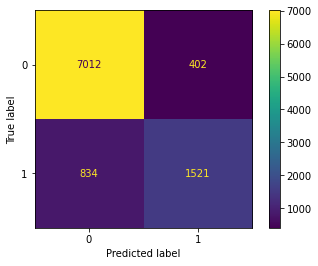

              precision    recall  f1-score   support

       <=50K       0.89      0.95      0.92      7414
        >50K       0.79      0.65      0.71      2355

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.87      0.87      9769



In [ ]:
y_predicted = pipeline_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format = 'd')
plt.show()
print(classification_report(y_test, y_predicted))

# Summary

## Feature engineering

We found some columns obsolete and removed them (explanation above). Other columns were one-hot encoded in a cool-looking preprocessing pipeline which later caused some difficulties with plotting feature importance for each model since column names where lost. 

Missing values were imputated because about 8% of values in 3 columns were missing.

Column with countries has special encoding - we compare the average percent of records for given country with income >50k with average percent of records for USA with income >50k. Countries with higher percentage are in one category, others are in different, USA is ommited. It is an unusual approach however this method would greatly benefit from more data about other countries.

## Early models

We have tested many different models with the same preprocessor pipeline and checked their stats. While every model got similar accuracy of about 0.86, there are some minor differences in other scores:
- recall of >50k is very low in every tested model,
- xgboost got the best scores in f1 score and aforementioned recall.

Overall we agreed that the models above did not have their hyperparameters tuned therefore no final model can be chosen after tests presented above.

Feature importance plots are a good place to find hints about columns selection in the final model - many features can be safely removed from the training data without much impact on the model. Some are crucial, such as being married.
